<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Image Classification Using InceptionV3

This Code Template is for simple image classification using InceptionV3. Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset.

### Required Packages

In [2]:
import os
import numpy as np
from glob import glob
import itertools
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

# TensorFlow Modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import InceptionV3

# Visualizations
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns

### Initialization
Path of the main folder containing train and test folders

In [3]:
base_dir = os.path.dirname('')

Path of the train and test folders containing image files

In [4]:
train_dir = os.path.join(base_dir, 'train') #train
test_dir = os.path.join(base_dir, 'test') #test

List of target categories which are required for model training and predictions.

In [5]:
target = []

### Data Fetching

The OS module in Python provides functions for interacting with the operating system. This module provides a portable way of using operating system-dependent functionality.

OpenCV-Python is a library of Python bindings designed to solve computer vision problems.

We will use the <Code>os.path</Code> module to interact with the file system and the <Code>cv2.imread()</Code> method to load an image from the specified file path.

### Directory Structure
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>Master Directory</b>
 |__<b>train</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
 |__<b>test</b>
    |______ <b>Class 1</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 2</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>Class 3</b>: [1.jpg, 2.jpg, 3.jpg ....]
    :
    :
</pre>

In [6]:
# useful for getting number of files
train_image_files = glob(train_dir + '/*/*.jp*g')
test_image_files = glob(test_dir + '/*/*.jp*g')

In [7]:
# Loading the image dataset and plotting some images from all target categories
def plot_image(data, target):
  count = 0
  for category in target:
      path=os.path.join(data, category)
      flg = 0
      ar = []
      # storing image paths in an array
      for img in os.listdir(path):
          ar.append(os.path.join(path,img)) 
          flg+= 1
          if flg==2:
            break
      # plotting the images in dataset
      plt.figure(figsize=(5,5))
      for i in range(2):
        d1 = ar[i]
        img_array = cv2.imread(d1,cv2.IMREAD_COLOR)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1,2,i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis("off")
      count+= 1
      if count == len(target):
        break

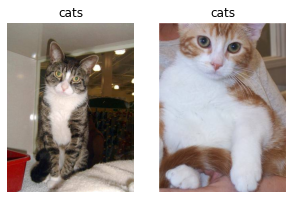

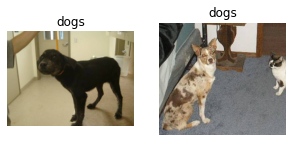

In [8]:
plot_image(train_dir,target)

### Data Preprocessing

An Image occupies a significant portion of space. Since images represent huge datasets, loading them at once to memory (RAM) can lead to severe scalibility issues and memory limitations. Therefore, in practice, images are loaded directly from the directory structure.   

TensorFlow 2 comes with a handy class called <Code>ImageDataGenerator</Code> that augments images. It takes the following parameters:


1. **rotation_range**:	Int. 
>Degree range for random rotations.

2. **width_shift_range**: Float, 1-D array-like or int
          * float: fraction of total width, if < 1, or pixels if >= 1.
          * 1-D array-like: random elements from the array.
          * int: integer number of pixels from interval (-width_shift_range, +width_shift_range)
          * With width_shift_range=2 possible values are integers [-1, 0, +1], same as with width_shift_range=[-1, 0, +1], while with width_shift_range=1.0 possible values are floats in the interval [-1.0, +1.0).

3. **height_shift_range**:	Float, 1-D array-like or int. 
>Values have similar meaning as width_shift_range

4. **zoom_range**:	Float or [lower, upper]. 
>Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
channel_shift_range	Float. Range for random channel shifts.

5. **horizontal_flip**:	Boolean. 
>Randomly flip inputs horizontally.


6. **rescale**:	rescaling factor. Defaults to None. 
>If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).

7. **data_format**	Image data format, either "channels_first" or "channels_last". 
>"channels_last" mode means that the images should have shape (samples, height, width, channels), "channels_first" mode means that the images should have shape (samples, channels, height, width). 


For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args)

In [9]:
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                         rotation_range=20,
                                         width_shift_range=.15,
                                         height_shift_range=.15,
                                         horizontal_flip=True,
                                         zoom_range=0.2,
                                         data_format = "channels_last")

test_datagenerator = ImageDataGenerator(rescale = 1./255) #No need for augmentation for test dataset

### Flow From Directory

<Code>ImageDataGenerator</Code> class uses the method <Code>flow_from_directory</Code> to load the images. However, for this method to work, it is necessary the directory follow the above directory structure.

<Code>flow_from_directory</Code> takes the path to a directory & generates batches of augmented data. It takes following parameters:

1. **directory**:	string, path to the target directory. 
>It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. 

2. **target_size**:	Tuple of integers (height, width), defaults to (256,256). 
>The dimensions to which all images found will be resized.
color_mode	One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

3. **classes**:	Default: None. 
>Optional list of class subdirectories (e.g. ['dogs', 'cats']). 

4. **class_mode**:	Default: "categorical". 
>One of "categorical", "binary", "sparse", "input", or None. 

5. **batch_size**:	Default: 32
>Size of the batches of data.

6. **shuffle**: Default: True
>Whether to shuffle the data. If set to False, sorts the data in alphanumeric order.

For more information, refer to the [API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [10]:
batch_size = 64 # number of images to process at a time 
IMG_SHAPE = 224 # convert all images to be 224 x 224

train_data = train_datagenerator.flow_from_directory(directory = train_dir,
                                                     batch_size = batch_size,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
                                                     shuffle = True, #for training only
                                                     class_mode = 'sparse', #type of problem (sparse, binary, or categorical, etc.)
                                                     classes = target)  

test_data = test_datagenerator.flow_from_directory(directory = test_dir,
                                                   batch_size = batch_size,
                                                   target_size = (IMG_SHAPE, IMG_SHAPE),
                                                   shuffle = False,
                                                   class_mode = 'sparse',
                                                   classes = target)

Found 2000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


### Model

Inception-v3 is a convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead).

For more information, refer to this [article](https://towardsdatascience.com/tagged/inception-v3).


### Parameters of InceptionV3
    
1. **include_top**: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.

2. **weights**: One of None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. Default to imagenet.
3. **input_tensor**: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. input_tensor is useful for sharing inputs between multiple different networks. Default to None.

4. **input_shape**: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) (with channels_last data format) or (3, 299, 299) (with channels_first data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75.

5. **pooling**: Optional pooling mode for feature extraction when include_top is False.
None (default) means that the output of the model will be the 4D tensor output of the last convolutional block.
avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
max means that global max pooling will be applied.

6. **classes**: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Default to 1000.

7. **classifier_activation**: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

For more information on InceptionV3, refer to this [article](https://keras.io/api/applications/inceptionv3/)

In [11]:
loss = "sparse_categorical_crossentropy" 
output_activation = 'softmax'
learning_rate = 0.0005 #Default = 0.001
epochs = 12
NUM_COLOR_CHANNELS = 3

In [12]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation=output_activation))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3276864   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 25,079,778
Trainable params: 25,045,346
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
# compile model
model.compile(loss=loss,
              optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['acc'])

In [23]:
# Fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=test_data)

Epoch 1/12
32/32 [==============================] - 549s 16s/step - loss: 2.2063 - acc: 0.6945 - val_loss: 8.4560 - val_acc: 0.5792
Epoch 2/12
32/32 [==============================] - 48s 1s/step - loss: 0.2277 - acc: 0.9160 - val_loss: 1.0727 - val_acc: 0.8941
Epoch 3/12
32/32 [==============================] - 48s 1s/step - loss: 0.2144 - acc: 0.9365 - val_loss: 1.4201 - val_acc: 0.8436
Epoch 4/12
32/32 [==============================] - 48s 1s/step - loss: 0.1441 - acc: 0.9515 - val_loss: 1.2353 - val_acc: 0.9149
Epoch 5/12
32/32 [==============================] - 48s 1s/step - loss: 0.1293 - acc: 0.9590 - val_loss: 4.6642 - val_acc: 0.8990
Epoch 6/12
32/32 [==============================] - 48s 1s/step - loss: 0.1197 - acc: 0.9545 - val_loss: 3.6703 - val_acc: 0.9000
Epoch 7/12
32/32 [==============================] - 48s 1s/step - loss: 0.1101 - acc: 0.9610 - val_loss: 282.8733 - val_acc: 0.5069
Epoch 8/12
32/32 [==============================] - 48s 1s/step - loss: 0.1319 - acc: 

### Plot Curves

Plot loss and accuracy metrics to see how the model trains

In [24]:
def plot_model(model_name_history, metric_name):
    # Plot loss per iteration
    fig, ax = plt.subplots(1, 2,figsize=(15,5))

    ax[0].plot(model_name_history.history['loss'], label='loss')
    ax[0].plot(model_name_history.history['val_loss'], label='val_loss')
    ax[0].legend()
    
    # Plot accuracy per iteration
    ax[1].plot(model_name_history.history[metric_name], label='accuracy')
    ax[1].plot(model_name_history.history[f"val_{metric_name}"], label='val_accuracy')
    ax[1].legend()

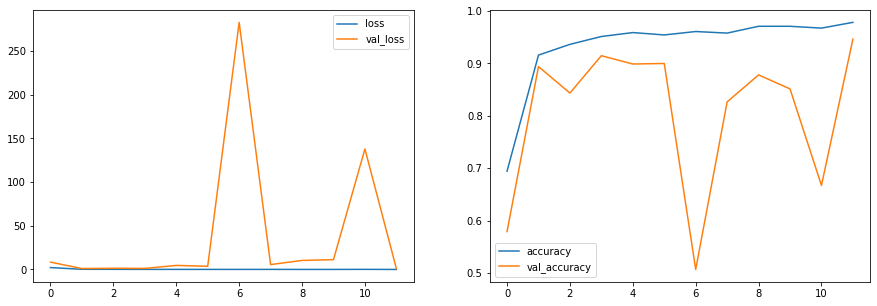

In [25]:
plot_model(history, 'acc')

### Model Evaluation (Accuracy)

In [26]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions,axis = 1)
y_test = test_data.classes
class_labels = list(test_data.class_indices.keys())   
loss, accuracy = model.evaluate(test_data)
print("Loss: ", loss)
print("Accuracy Score: ",accuracy)

16/16 [==============================] - 6s 366ms/step - loss: 1.0933 - acc: 0.9465
Loss:  1.0932536125183105
Accuracy Score:  0.9465346336364746


### Confusion Matrix

A confusion matrix is utilized to understand the performance of the classification model or algorithm in machine learning for a given test set where results are known.

In [27]:
def get_confusion_matrix(data, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in data:
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    y_pred = np.argmax(p,axis = 1)
    predictions = np.concatenate((predictions, y_pred))
 
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break
  cm = confusion_matrix(targets, predictions)
  return cm

Generating confusion matrix 1010


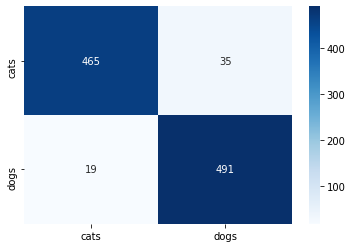

In [28]:
cm = get_confusion_matrix(test_data, len(test_image_files))
sns.heatmap(cm,
            annot = True,
            fmt = 'd',
            xticklabels=class_labels, 
            yticklabels= class_labels,
            cmap = plt.cm.Blues)
plt.show()

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True, how many are False.

* **where**:
    - Precision:- Accuracy of positive predictions.
    - Recall:- Fraction of positives that were correctly identified.
    - f1-score:-  percent of positive predictions were correct
    - support:- Support is the number of actual occurrences of the class in the specified dataset.

In [29]:
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

        cats       0.96      0.93      0.95       500
        dogs       0.93      0.96      0.95       510

    accuracy                           0.95      1010
   macro avg       0.95      0.95      0.95      1010
weighted avg       0.95      0.95      0.95      1010



#### Creator: Neel Pawar, Github: [Profile]( https://github.com/neel-ntp)